In [ ]:
import torch
from models import HapbertaForMaskedLM
from datasets import load_from_disk
from collators import HaploSimpleDataCollator
import matplotlib.pyplot as plt

In [2]:
model = HapbertaForMaskedLM.from_pretrained(
    "./models/hapberta2d/",
    torch_dtype=torch.bfloat16
)
# model = HapbertaForSequenceClassification.from_pretrained(
#     "./models/hapberta2d_pop/checkpoint-500/",
#     num_labels=3,
# )
model.to("cuda")
model.eval()
model.compile()

In [3]:
ds = load_from_disk("dataset2/tokenized")
collator = HaploSimpleDataCollator(mlm_probability=0, subsample=32)

ds = ds.shuffle().select(range(512))

# attention maps

In [10]:
# one example
inputs = collator([ds[0]])

for k in inputs:
    if isinstance(inputs[k], torch.Tensor):
        inputs[k] = inputs[k].to("cuda")

with torch.no_grad():
    outputs = model(inputs["input_ids"], inputs["distances"], inputs["attention_mask"], return_attentions=True)

In [12]:
row_attn, col_attn = outputs["attentions"]

idx = -1
row_attn, col_attn = row_attn[idx].to(torch.float16).cpu().numpy(), col_attn[idx].to(torch.float16).cpu().numpy()

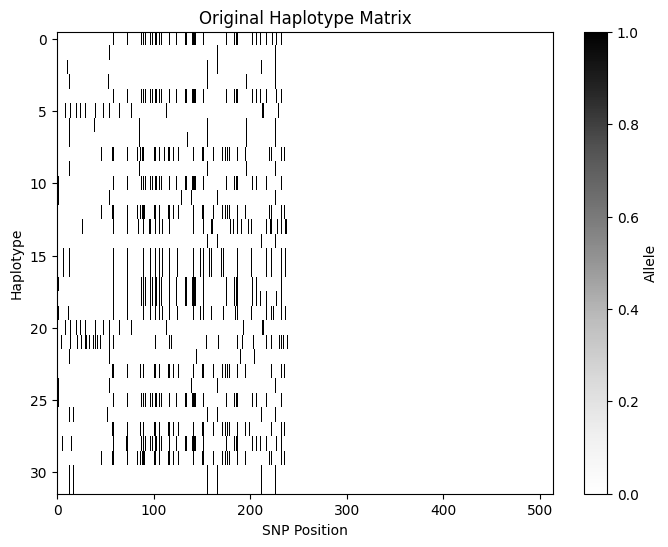

In [16]:
haps = inputs["input_ids"].cpu().numpy()[0]
haps[(haps > 1)] = 0
plt.figure(figsize=(8, 6))
plt.imshow(haps[:, :], aspect='auto', cmap='Greys', interpolation="none")
plt.xlabel("SNP Position")
plt.ylabel("Haplotype")
plt.title("Original Haplotype Matrix")
plt.colorbar(label="Allele")
plt.show()

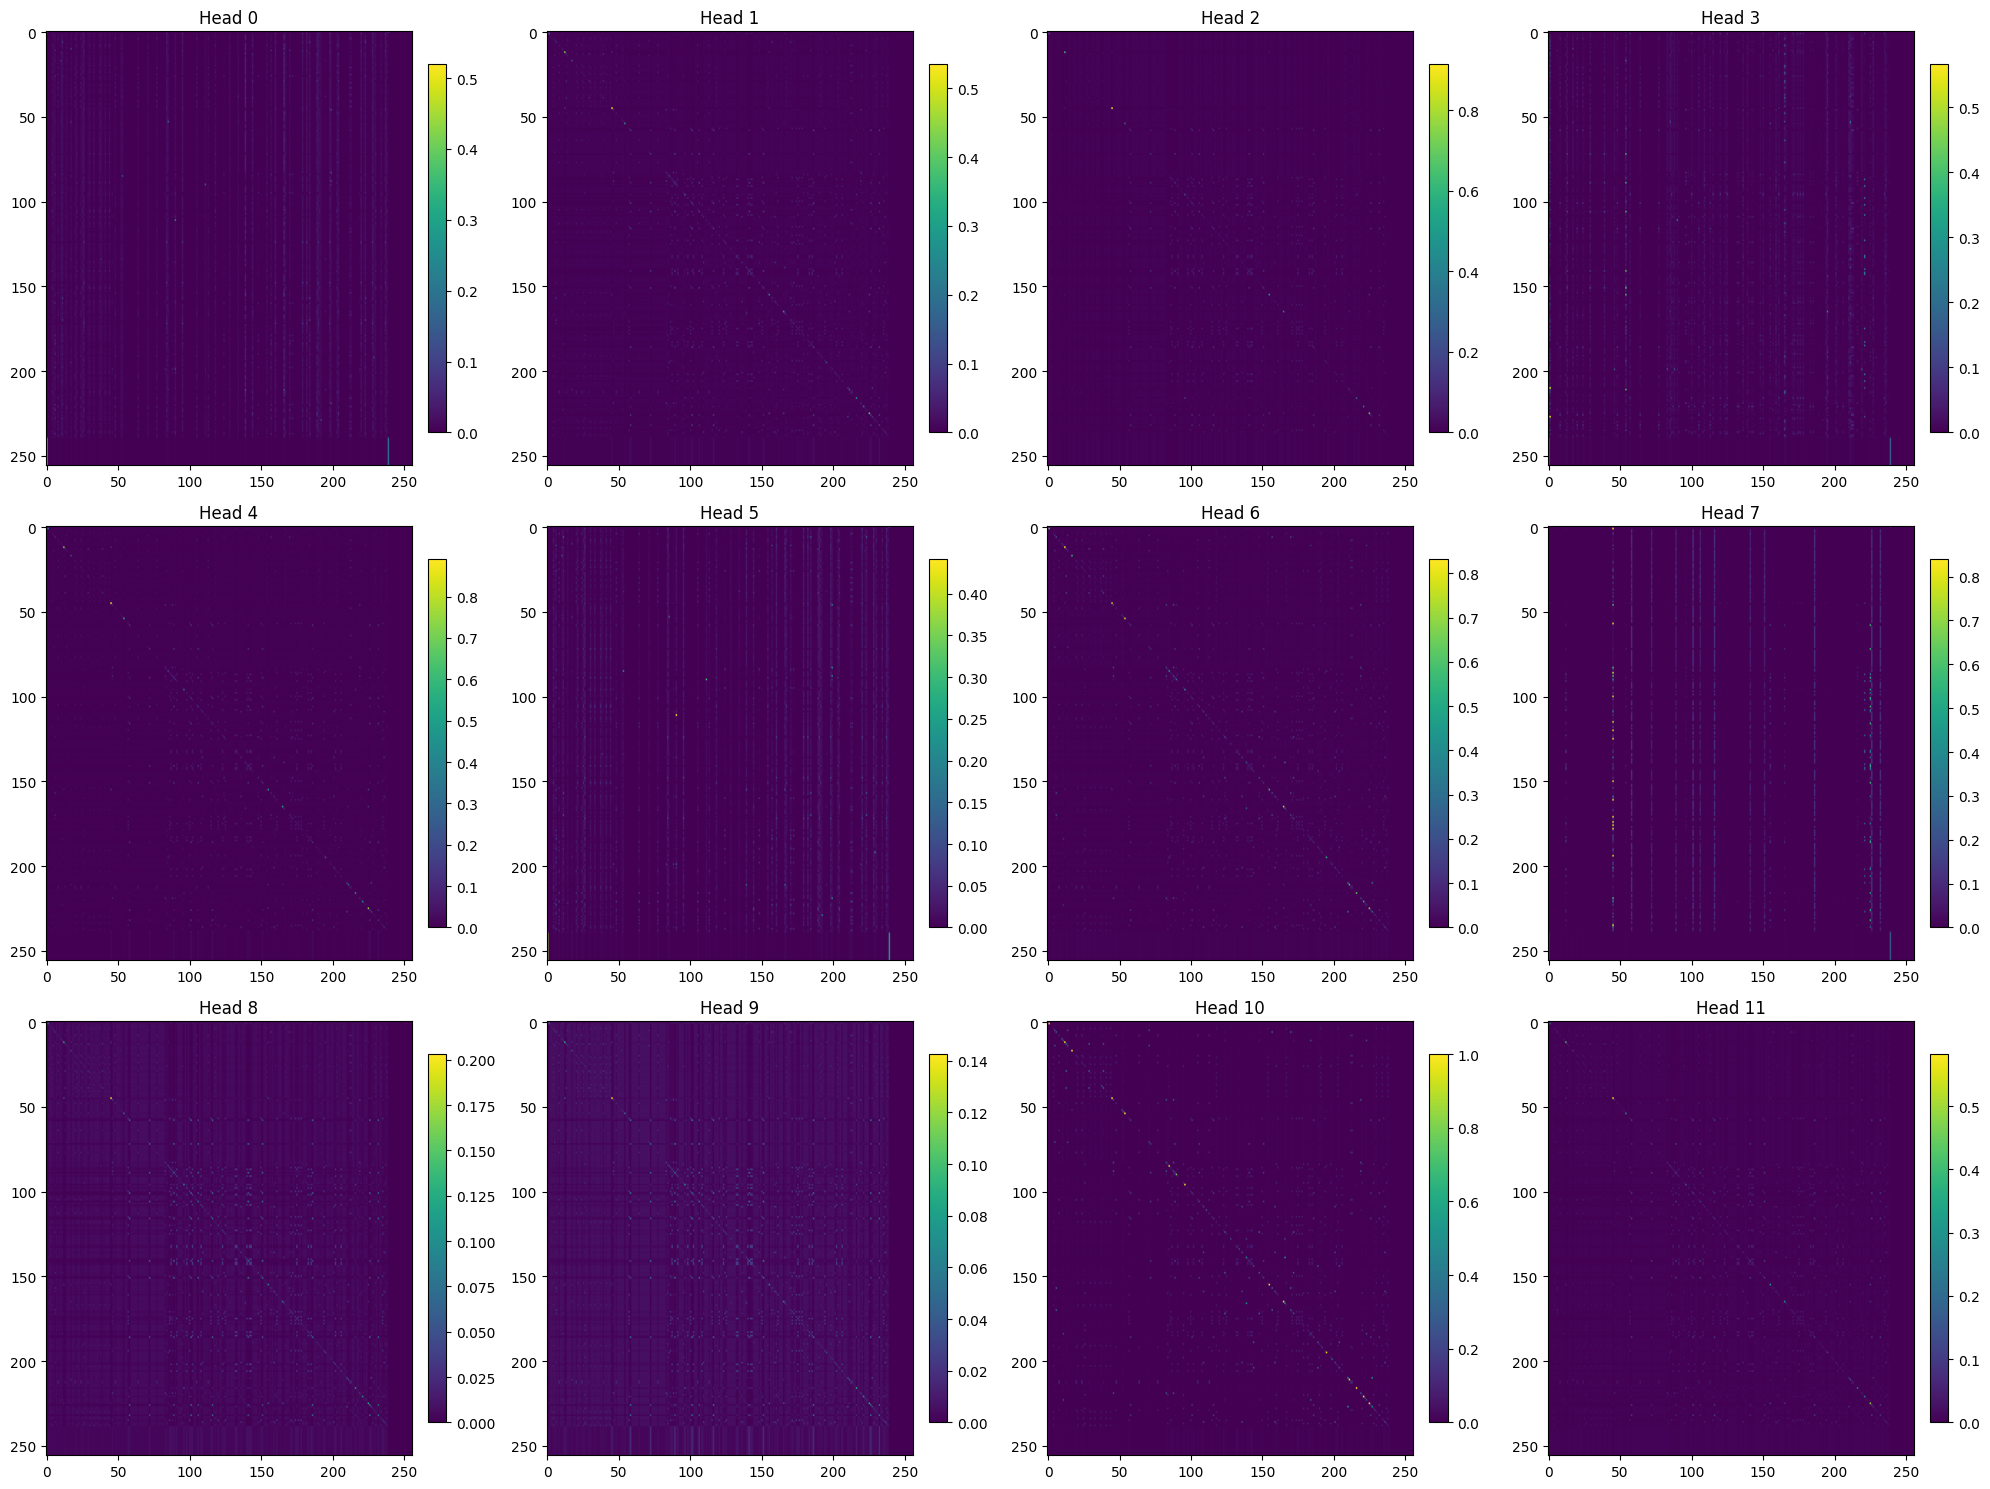

In [20]:
# Plot row attention maps for each head in layer idx
num_heads = row_attn.shape[0]
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i in range(num_heads):
    ax = axes[i]
    im = ax.imshow(row_attn[i, 0, :256, :256], aspect='auto', cmap='viridis')
    ax.set_title(f'Head {i}')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

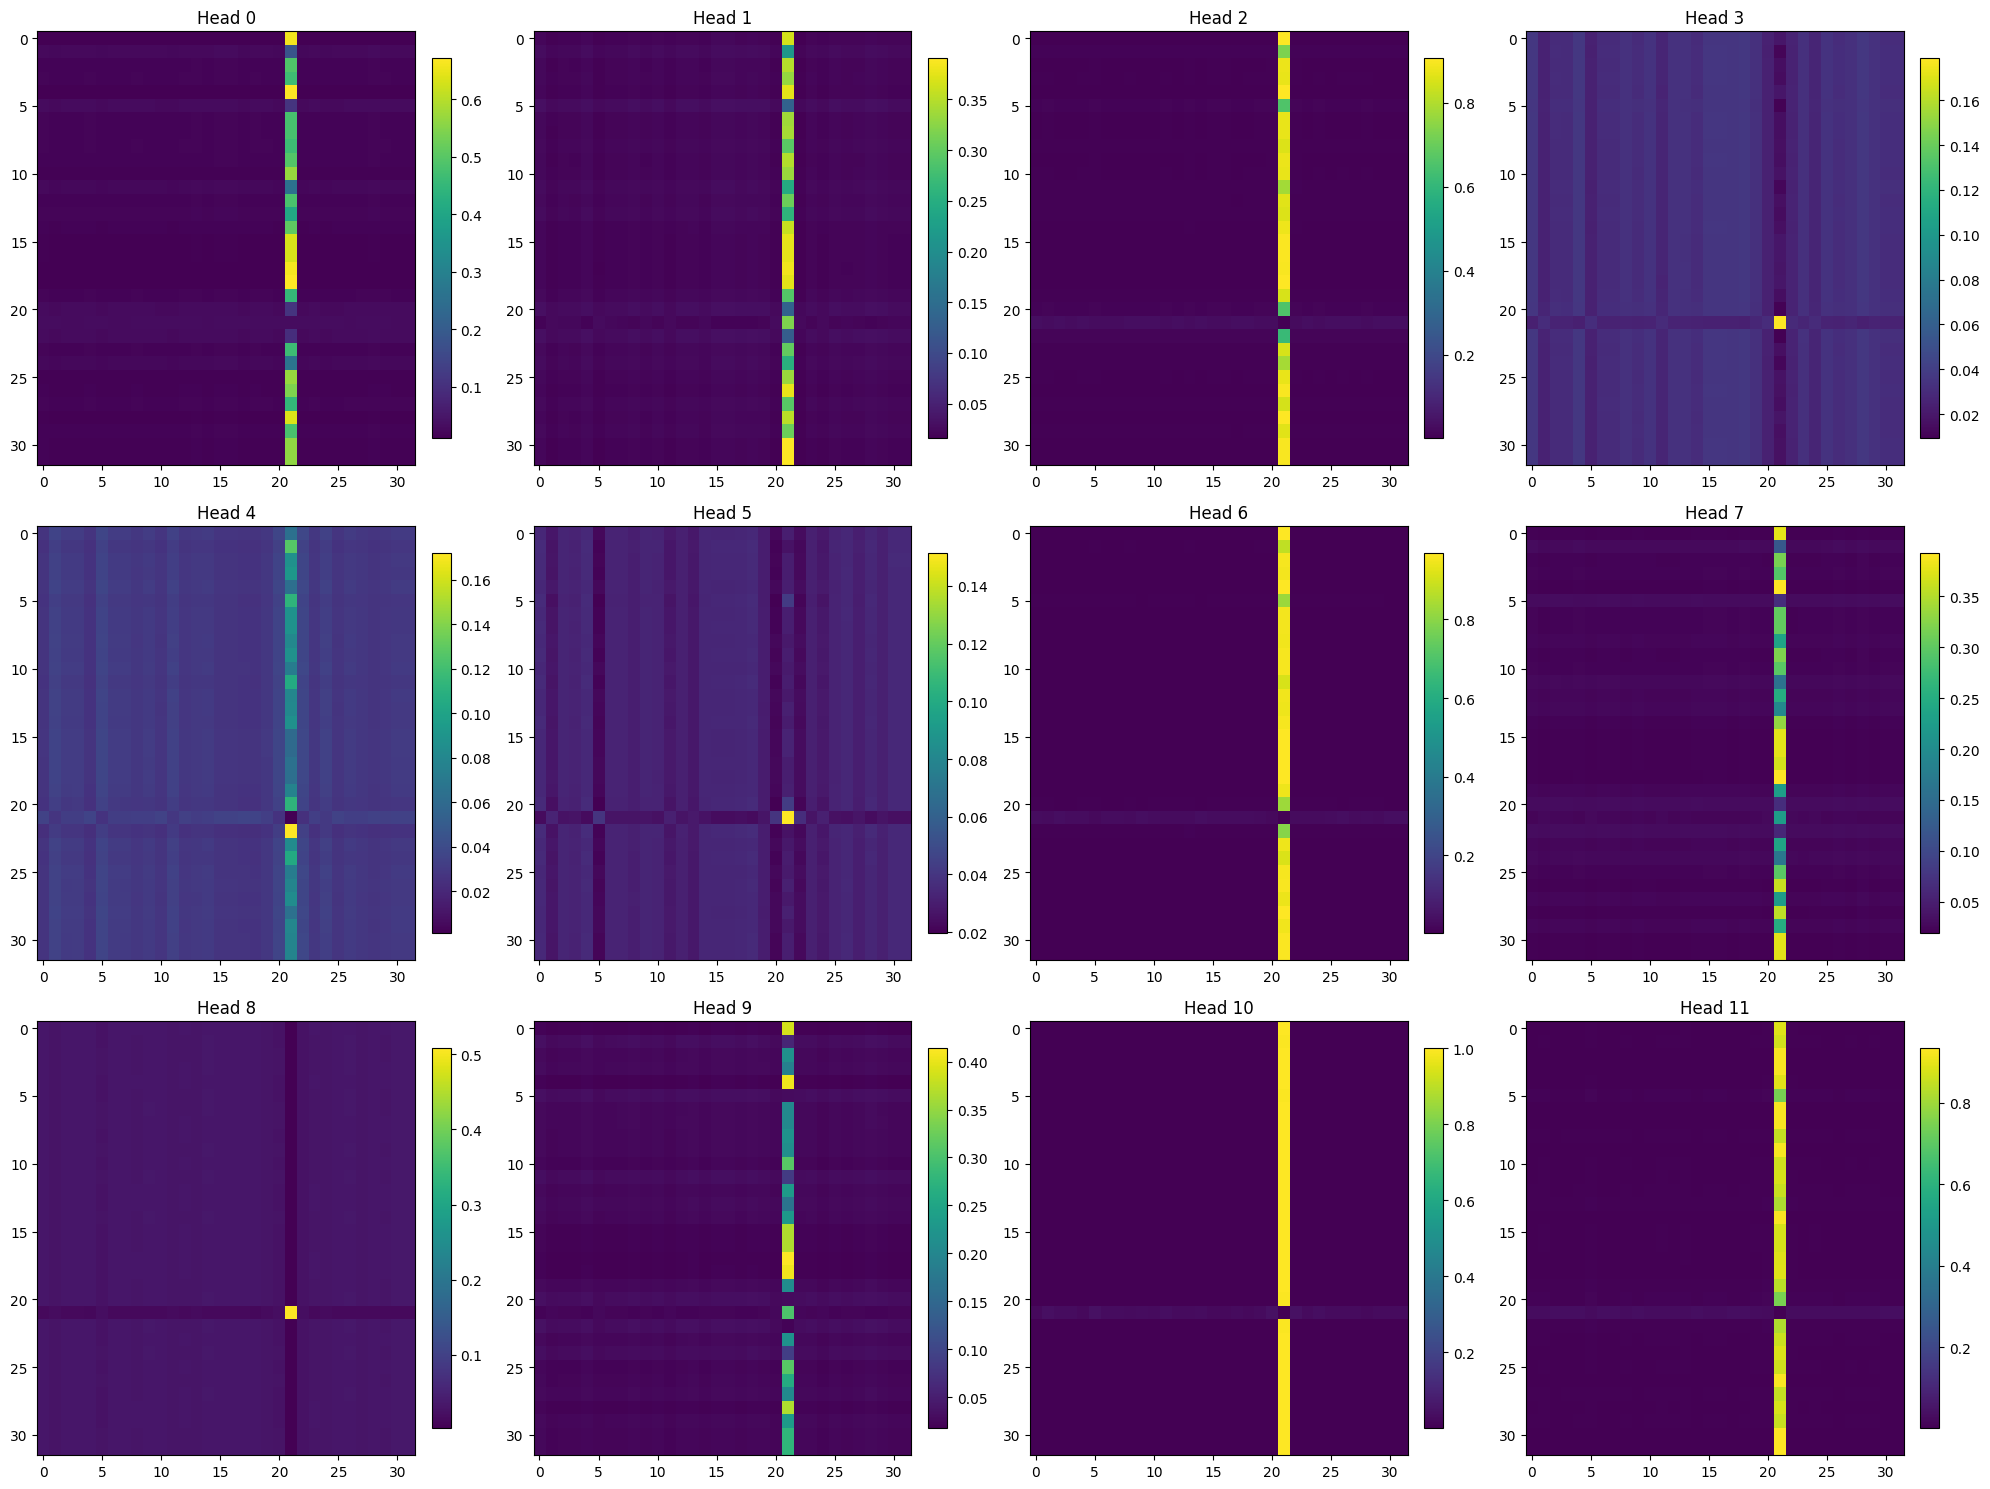

In [24]:
# Plot col attention maps for each head in layer idx
snp_pos = 4
num_heads = col_attn.shape[0]
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i in range(num_heads):
    ax = axes[i]
    im = ax.imshow(col_attn[i, snp_pos, 0], aspect='auto', cmap='viridis')
    ax.set_title(f'Head {i}')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()